# Ligand Similarity per X
Look at distribution of Tanimoto coeffs for the Kinase groups and families, as well as per individual kinase proteins and assays.
You need to run `process_similarity_by_cluster.py` before running this notebook. 

In [24]:
DATA_DIR = "/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/"

## Setup

In [25]:
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle
from math import comb

In [26]:
def load_from_pkl(save_path: str) -> object:
    with open(save_path, "rb") as f:
        obj = pickle.load(f)
    return obj

## Overall Distribution

In [27]:
MIN_VAL = 0.0
MAX_VAL = 1.0

In [28]:
SIM_MAT = np.load(os.path.join(DATA_DIR, "compound_structures", "similarity_lower_triangular_matrix.npy"))

In [29]:
SIM_MAT.shape

(49945015,)

In [30]:
# calculating number of ligands from size of matrix
L = SIM_MAT.shape[0] # number of elements in lower-triangular mat
# from fact that N (N_LIGANDS) has relation: N^2 = N + 2L (also note L = N choose 2)
N_LIGANDS = (1 + np.sqrt(1 + (8 * L))) / 2
assert N_LIGANDS.is_integer()
print(N_LIGANDS)
N_LIGANDS = int(N_LIGANDS)

9995.0


In [31]:
scipy.stats.describe(SIM_MAT)

DescribeResult(nobs=49945015, minmax=(np.float64(0.0), np.float64(1.0)), mean=np.float64(0.13642800255772977), variance=np.float64(0.0027285236313576633), skewness=np.float64(3.3842191996351185), kurtosis=np.float64(26.476067212320135))

In [32]:
np.median(SIM_MAT)

np.float64(0.12871287128712872)

In [33]:
# extreme cases
# I've double-checked all SMILES values are unique - exactly 505 pairs of fingerprints are identical
print("1.0 values:", (SIM_MAT == 1.0).sum())

1.0 values: 505


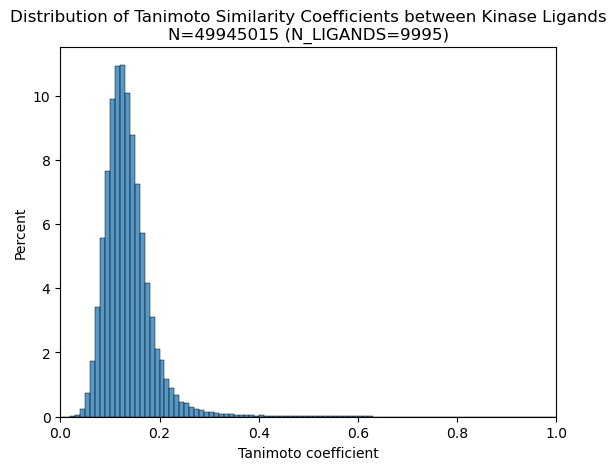

In [34]:
sns.histplot(SIM_MAT, bins=100, stat="percent")
plt.title(f"Distribution of Tanimoto Similarity Coefficients between Kinase Ligands\nN={L} (N_LIGANDS={N_LIGANDS})")
plt.xlabel("Tanimoto coefficient")
plt.xlim(MIN_VAL, MAX_VAL)
plt.show()

## Looking at distribution for kinase groups (class_level=4)

In [35]:
family_info_df = pl.read_csv(os.path.join(DATA_DIR,"targets/family_addl_info.tsv"), separator="\t")
family_info_df = family_info_df.with_columns((pl.col("short_name").str.to_uppercase()))

In [36]:
DICT_PATH_CL4 = os.path.join(DATA_DIR, "processed_similarity_cluster_data", f"cluster2sim_class_level=4.pkl")
cluster_dict_cl4 = load_from_pkl(DICT_PATH_CL4)

In [37]:
LC_PATH_CL4 = os.path.join(DATA_DIR, "family_clusters", "ligand2cluster-class_level=4.tsv")
ligand_cluster_cl4_df = pl.read_csv(LC_PATH_CL4, separator="\t")

In [38]:
ligand_cluster_cl4_df = ligand_cluster_cl4_df.join(family_info_df, on="protein_class_id")

In [39]:
ligand_cluster_cl4_df.head()

molregno,tid,protein_class_id,cluster,parent_id,pref_name,short_name,class_level
i64,i64,i64,i64,i64,str,str,i64
148,10044,158,2,1100,"""Other protein kinase group""","""OTHER""",4
213,10850,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4
213,10850,1289,4,1100,"""AGC protein kinase group""","""AGC""",4
213,10839,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4
213,11843,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4


In [40]:
# sanity checks
assert (len(cluster_dict_cl4.keys()) == ligand_cluster_cl4_df["cluster"].n_unique())
for cluster_tup, cluster_df in ligand_cluster_cl4_df.group_by("cluster"):
    cluster_id = cluster_tup[0]
    dict_n_pairs = len(cluster_dict_cl4[cluster_id])
    df_n_pairs = comb(cluster_df["molregno"].n_unique(), 2)
    assert dict_n_pairs == df_n_pairs, f"Mismatch with cluster={cluster_id} ({dict_n_pairs} != {df_n_pairs})"

In [41]:
cluster2name_df = ligand_cluster_cl4_df[["cluster", "short_name"]].unique().sort(by="cluster")
cluster2name_dict = dict(zip(cluster2name_df["cluster"], cluster2name_df["short_name"]))
cluster2name_dict

{1: 'CMGC',
 2: 'OTHER',
 3: 'TK',
 4: 'AGC',
 5: 'CK1',
 6: 'STE',
 7: 'TKL',
 8: 'CAMK',
 9: 'ATYPICAL'}

In [42]:
exclude_clusters = ["ATYPICAL", "OTHER"]
cluster_order = ['CK1', 'STE', 'CAMK', 'AGC', 'TKL', 'CMGC', 'TK'] # this is from the other notebook - just to make colors match short_name between plots

In [43]:
max_size = 1_000_000

In [44]:
cl4_dict = {cluster2name_dict[k]: np.random.choice(vals, min(len(vals), max_size), replace=False) for k, vals in cluster_dict_cl4.items() if cluster2name_dict[k] not in exclude_clusters}
cl4_dict["ALL KINASE"] = np.random.choice(SIM_MAT, max_size, replace=False)

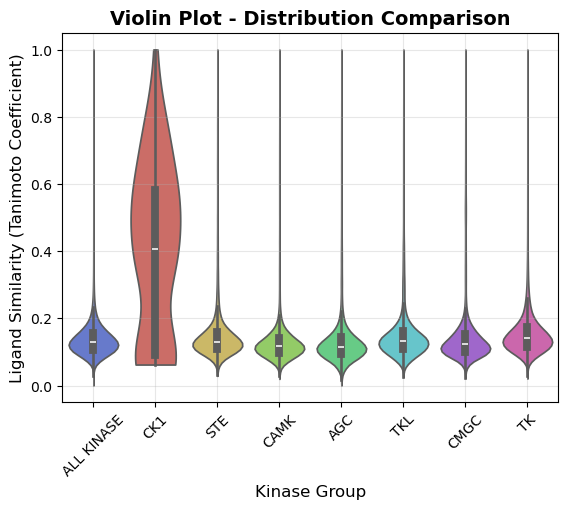

In [45]:
order = ["ALL KINASE"] + cluster_order
i = 5
hue_order = cluster_order[:i] + ["ALL KINASE"] + cluster_order[i:]
sns.violinplot(data=cl4_dict, palette='hls', cut=0, order=order, hue_order=hue_order)
plt.title('Violin Plot - Distribution Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Kinase Group', fontsize=12)
plt.ylabel('Ligand Similarity (Tanimoto Coefficient)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

In [46]:
for k in cluster_order:
    print(k)
    print(scipy.stats.describe(cl4_dict[k]))
    print("-"*80)

CK1
DescribeResult(nobs=78, minmax=(np.float64(0.0625), np.float64(1.0)), mean=np.float64(0.40695749690162547), variance=np.float64(0.06442486713140455), skewness=np.float64(0.05493171665173104), kurtosis=np.float64(-1.0163531526913159))
--------------------------------------------------------------------------------
STE
DescribeResult(nobs=90100, minmax=(np.float64(0.028846153846153848), np.float64(1.0)), mean=np.float64(0.15246523908832418), variance=np.float64(0.008845248191940096), skewness=np.float64(4.0412478589568614), kurtosis=np.float64(20.208591035643366))
--------------------------------------------------------------------------------
CAMK
DescribeResult(nobs=177906, minmax=(np.float64(0.019801980198019802), np.float64(1.0)), mean=np.float64(0.13276843531736063), variance=np.float64(0.006947708770816791), skewness=np.float64(4.894920888203395), kurtosis=np.float64(29.89708811797989))
--------------------------------------------------------------------------------
AGC
Describ

## Distribution for kinase families (class_level=5)

In [47]:
def plot_vals(vals: list, title: str, xlabel: str = "Tanimoto coefficient", min_val: float = 0.0, max_val: float = 1.0):
    sns.histplot(vals, stat="percent")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xlim(min_val, max_val)
    plt.show()

In [48]:
MIN_N_OBS = 1 # there must be at least one similarity value - ie 2 ligands per cluster

In [49]:
DICT_PATH_CL5 = os.path.join(DATA_DIR, "processed_similarity_cluster_data", f"cluster2sim_class_level=5.pkl")
cluster_dict_cl5 = load_from_pkl(DICT_PATH_CL5)

In [50]:
cl5_mean_vals = [np.mean(l) for l in cluster_dict_cl5.values() if len(l) >= MIN_N_OBS]
cl5_median_vals = [np.median(l) for l in cluster_dict_cl5.values() if len(l) >= MIN_N_OBS]

In [51]:
print(len(cl5_mean_vals))
print(len(cluster_dict_cl5)) # not all clusters have enough observations

82
86


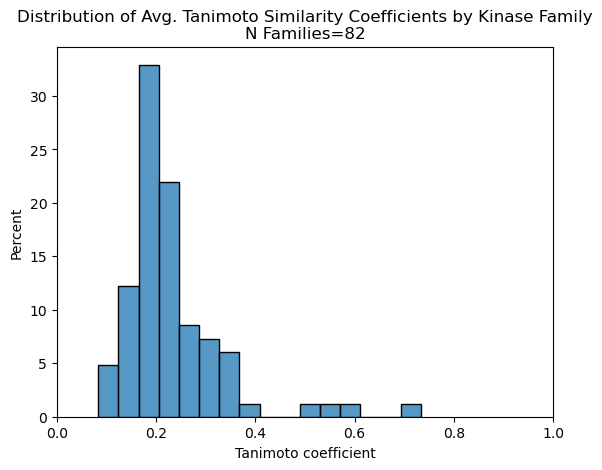

In [52]:
title = f"Distribution of Avg. Tanimoto Similarity Coefficients by Kinase Family\nN Families={len(cl5_mean_vals)}"
plot_vals(cl5_mean_vals, title)

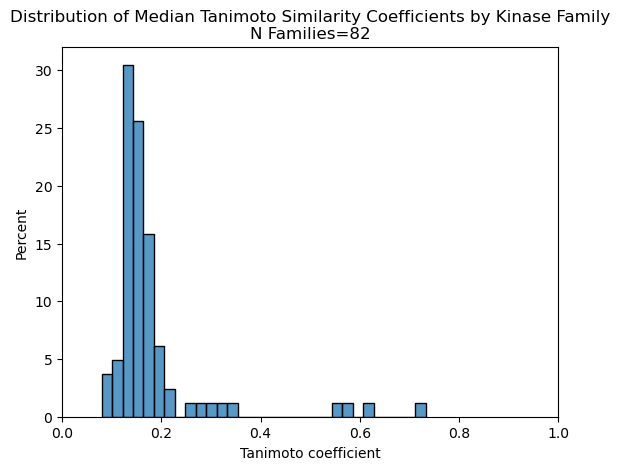

In [53]:
title = f"Distribution of Median Tanimoto Similarity Coefficients by Kinase Family\nN Families={len(cl5_median_vals)}"
plot_vals(cl5_median_vals, title)

## Distribution per Target
Look at Tanimoto similarity values on a per-target basis, rather than per target family.

In [56]:
DICT_PATH_TID = os.path.join(DATA_DIR, "processed_similarity_cluster_data", f"tid2sim.pkl")
tid_dict = load_from_pkl(DICT_PATH_TID)

In [57]:
len(tid_dict)

289

In [58]:
tid_mean_vals = [np.mean(l) for l in tid_dict.values() if len(l) >= MIN_N_OBS]
tid_median_vals = [np.median(l) for l in tid_dict.values() if len(l) >= MIN_N_OBS]

In [59]:
print("TID Mean Similarities Distribution:", scipy.stats.describe(tid_mean_vals))
print("TID Median Similarities Distribution:", scipy.stats.describe(tid_median_vals))

TID Mean Similarities Distribution: DescribeResult(nobs=235, minmax=(np.float64(0.07339449541284404), np.float64(0.7894736842105263)), mean=np.float64(0.2775454765095615), variance=np.float64(0.017473884327641506), skewness=np.float64(1.3843986664350927), kurtosis=np.float64(2.2969912354402897))
TID Median Similarities Distribution: DescribeResult(nobs=235, minmax=(np.float64(0.07339449541284404), np.float64(0.7894736842105263)), mean=np.float64(0.22403937512393388), variance=np.float64(0.02338177363572509), skewness=np.float64(1.9458427426040306), kurtosis=np.float64(3.160320358342249))


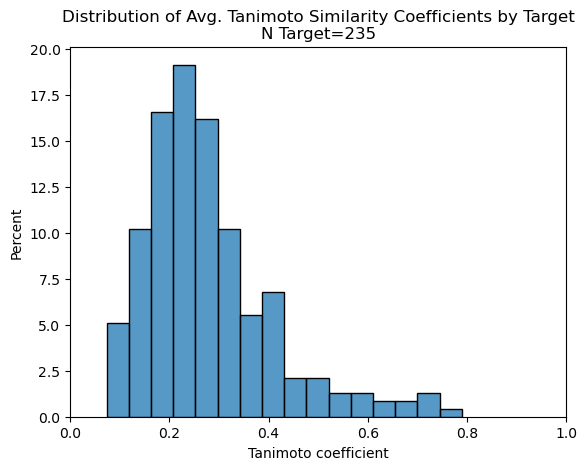

In [60]:
title = f"Distribution of Avg. Tanimoto Similarity Coefficients by Target\nN Target={len(tid_mean_vals)}"
plot_vals(tid_mean_vals, title)

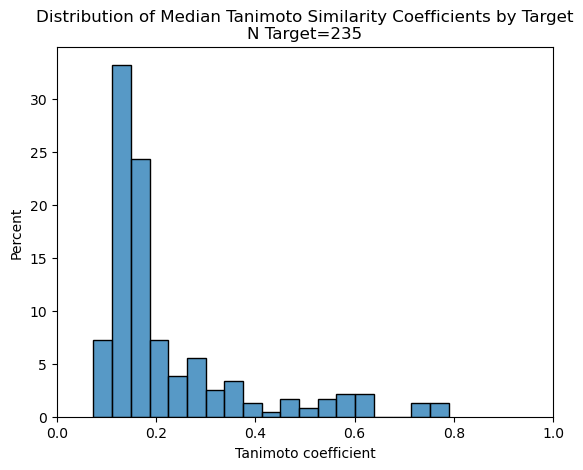

In [61]:
title = f"Distribution of Median Tanimoto Similarity Coefficients by Target\nN Target={len(tid_median_vals)}"
plot_vals(tid_median_vals, title)

## Distribution per Assay
Look at Tanimoto similarity values on a per-assay basis.

In [62]:
DICT_PATH_ASSAY = os.path.join(DATA_DIR, "processed_similarity_cluster_data", "assay2sim.pkl")
assay_dict = load_from_pkl(DICT_PATH_ASSAY)

In [63]:
len(assay_dict)

4231

In [64]:
assay_mean_vals = [np.mean(l) for l in assay_dict.values() if len(l) >= MIN_N_OBS]
assay_median_vals = [np.median(l) for l in assay_dict.values() if len(l) >= MIN_N_OBS]

In [65]:
print("Assay Mean Similarities Distribution:", scipy.stats.describe(assay_mean_vals))
print("Assay Median Similarities Distribution:", scipy.stats.describe(assay_median_vals))

Assay Mean Similarities Distribution: DescribeResult(nobs=1861, minmax=(np.float64(0.05555555555555555), np.float64(1.0)), mean=np.float64(0.5910092034576064), variance=np.float64(0.03727691563567885), skewness=np.float64(-0.8901204672171437), kurtosis=np.float64(0.3994876692552749))
Assay Median Similarities Distribution: DescribeResult(nobs=1861, minmax=(np.float64(0.05555555555555555), np.float64(1.0)), mean=np.float64(0.5806572517231218), variance=np.float64(0.041499989783285916), skewness=np.float64(-0.8647287239035436), kurtosis=np.float64(0.15567205101809733))


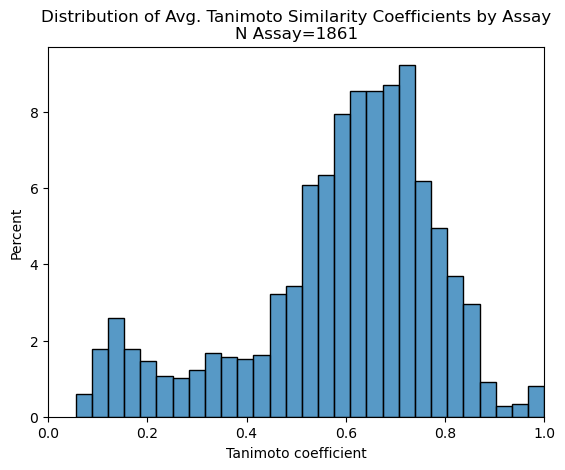

In [66]:
title = f"Distribution of Avg. Tanimoto Similarity Coefficients by Assay\nN Assay={len(assay_mean_vals)}"
plot_vals(assay_mean_vals, title)

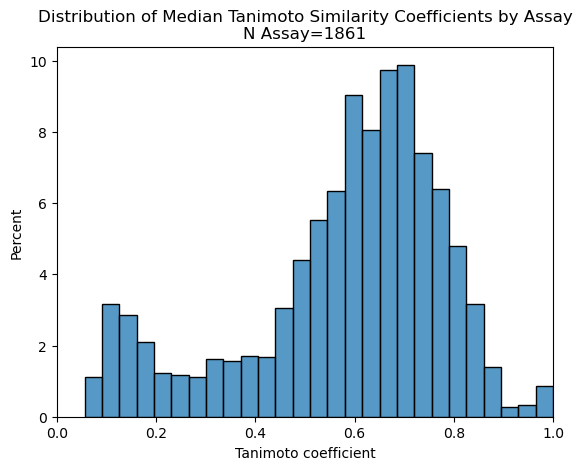

In [67]:
title = f"Distribution of Median Tanimoto Similarity Coefficients by Assay\nN Assay={len(assay_median_vals)}"
plot_vals(assay_median_vals, title)